# Individual Project 
- Aditya Khadkikar, 1MS049 Computer Intensive Statistics at Uppsala University.

Research Question:
> - Can we estimate missing glucose and cholesterol values using Expectation Maximization (EM), and can we improve a CHD binary prediction model using the new simulated data points?

Dataset: https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset/data

## **Plan**
- Select variables `[totChol, glucose]`, which consist of null values scattered arbitrarily.
- Model them as multivariate normal (not perfect, but mathematically tractable) combinations of the rest of the known features.

## **Run EM:**
- E-step: conditional expectation of missing entries.
- M-step: update covariance and mean.

Compare CHD prediction performance with and without EM-augmented data.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from scipy.stats import gamma
from scipy.integrate import quad

In [10]:
df_first = pd.read_csv("framingham.csv")
print("number of rows", len(df_first)) # number of rows
df = df_first.dropna()
print("number of rows without missing values", len(df), '\n----------------') # number of rows without missing values
print(df.columns)
df

number of rows 4240
number of rows without missing values 3658 
----------------
Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0


In [3]:
print("----------------\n"+str(df.dtypes))
df_first.isna().sum()

----------------
male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object


male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

As can be seen, there are a lot of `glucose` values that are missing (or N/A). Similarly, some `totChol` values are also missing, and if they can be estimated through EM, the model can be trained more thoroughly, and more data can be provided to allow for better prediction.

This has a meaningful application, as sometimes getting data can be challenging, or readings can be missing for certain features, hence with the data that is present, the null values can be filled using EM method.

In [4]:
X = df[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']].to_numpy()
y = df['TenYearCHD'].to_numpy()
print(len(y[y==1])) # positive for CHD in 10 years
print(len(y[y==0])) # negative for CHD in 10 years

557
3101


In [6]:
df['education'].describe()

count    3658.000000
mean        1.980317
std         1.022656
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: education, dtype: float64

In [ ]:
def nominal_to_bern_dist(feature_name):
    theta = df[[feature_name]].sum()/len(df[[feature_name]])

prevalentHyp    0.311646
dtype: float64

(array([ 20., 190., 438., 443., 449., 379., 375., 358., 310., 289., 267.,
        118.,  22.]),
 array([32.        , 34.92307692, 37.84615385, 40.76923077, 43.69230769,
        46.61538462, 49.53846154, 52.46153846, 55.38461538, 58.30769231,
        61.23076923, 64.15384615, 67.07692308, 70.        ]),
 <BarContainer object of 13 artists>)

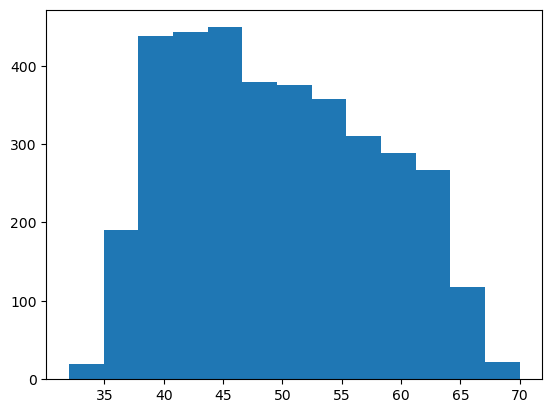

In [166]:
plt.hist(df[['age']], bins=13)

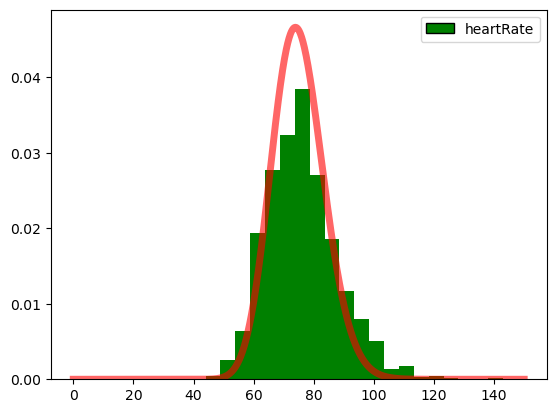

In [269]:
# plotting a gamma distribution
x = np.linspace(0, 150, 1000)
plt.plot(x, gamma.pdf(x, 74, 0.9), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.legend([Rectangle((0,0),1,1,color='green',ec='k')], ["heartRate"])
plt.hist(df[['heartRate']].to_numpy(), bins=20, color='green', density=True)
plt.show()

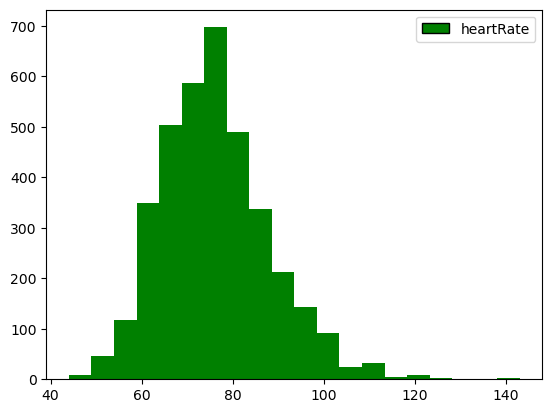

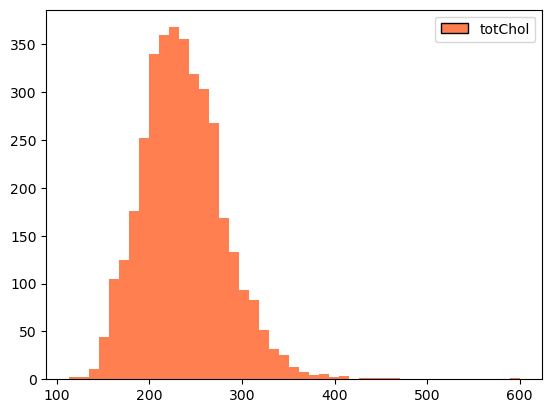

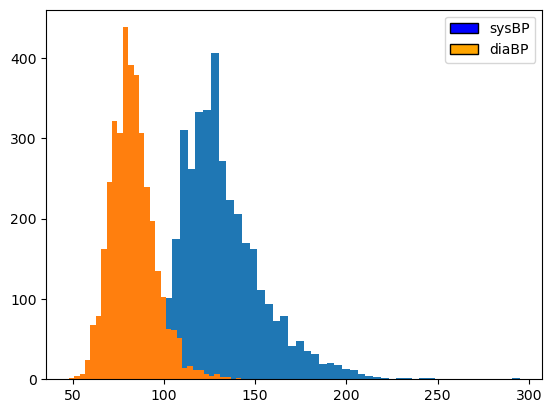

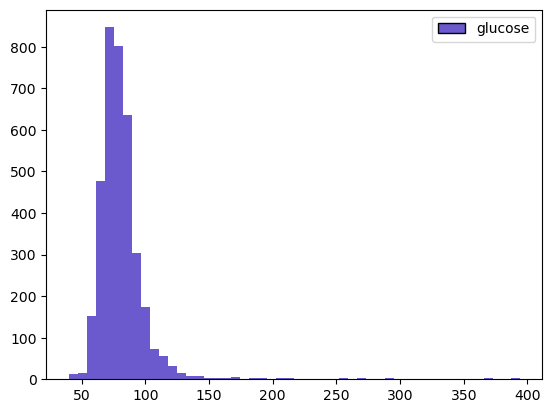

In [ ]:
plt.legend([Rectangle((0,0),1,1,color='green',ec='k')], ["heartRate"])
plt.hist(df[['heartRate']].to_numpy(), bins=20, color='green')
plt.show()
plt.hist(df[['totChol']].to_numpy(), bins=45, color='coral')
plt.legend([Rectangle((0,0),1,1,color='coral',ec='k')], ["totChol"])
plt.show()
plt.hist(df[['sysBP']].to_numpy(), bins=50)
plt.hist(df[['diaBP']].to_numpy(), bins=32)
legends = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["blue", "orange"]]
labels = ["sysBP", "diaBP"]
plt.legend(legends, labels)
plt.show()
plt.hist(df[['glucose']].to_numpy(), bins=50, color='slateblue')
plt.legend([Rectangle((0,0),1,1,color='slateblue',ec='k')], ["glucose"])
plt.show()

## **Fitting a basic LogisticReg model (before EM)**

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(X_train, y_train)
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))

train accuracy: 0.8555805725313606
test accuracy: 0.843351548269581


## **EM Algorithm**

In [154]:
# Total Cholesterol data
X = df[['totChol', 'heartRate', 'sysBP', 'diaBP', 'glucose']].to_numpy()
y = df['TenYearCHD'].to_numpy()

1. Start with $\mu_0=75$, $\sigma_0=1$.
$$
E = \int_X{p(x|\mu_0)\ln(L(x,1,2,..|\mu))dx}
$$
2. E will be a function of the variable's true value we are after ($\mu$). Finally, the M step will be an optimization step.
$$
\mu_1 = \argmax_{\mu}{E(\mu)}
$$

First example: `heartRate`

Maximum and minimum values it can have: $[30, 150]$. 
All of the heart rates sampled are independent, hence it will be a sum of log-probabilities.

$$
\int_{x=30}^{150}{p(x|\mu_0){\ln(L(x,...|\mu,\sigma))}dx}
$$
$$
= \int_{x=30}^{150}{p(x|\mu_0) {\ln(L(x|\mu,\sigma)*L(1|\mu,\sigma)*L(2|\mu,\sigma)...)}dx}
$$

> Note: $\mu$ is simply one example of the parameter for which we solve using EM. This same process is repeated for the standard deviation $\sigma$, or the variance $\sigma^2$, as well.

In [ ]:
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

def integrand(x, a_prop, scale_prop, a_, scale_):
    return gamma.pdf(x, a_prop, scale=scale_prop)*(np.sum(np.log(gamma.pdf(df['heartRate'].to_numpy(), a_, scale=scale_))) + np.log(gamma.pdf(x, a_, scale=scale_))) # Example function; replace with actual computation


def objective(a_prop, scale_prop, a_domain, scale_domain, sign=1): # make sure to pass sign=-1 for maximization
    # theta is [a, scale] for our Gamma we want to fit
    computed_integral = quad(integrand, 30, 160, args=(a_prop, scale_prop, a_domain, scale_domain))
    return sign*computed_integral[0], computed_integral[1] # returns [integral value, error estimate]

# sample input range uniformly at 0.1 increments
a_star = arange(60, 80, 0.5) # a
scale_star = arange(0.5, 1.5, 0.05) # scale
# create a mesh from the axis
x, y = meshgrid(a_star, scale_star)

data = np.zeros((len(a_star)*len(scale_star), 3))
i = 0
initial_a, initial_s = 20, 0.5
for a in a_star:
    for s in scale_star:
        print(objective(initial_a, initial_s, a, s, sign=-1))
        data[i] = [a, s, objective(initial_a, initial_s, a, s, sign=-1)[0]]
        i += 1

# create a surface plot with the jet color scheme
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
# show the plot
plt.show()

print(np.argmin(data[:,2]))

## **Before**

In [451]:
gamma.fit(df['heartRate'].to_numpy())

(np.float64(14.040839110811838),
 np.float64(31.107993527336298),
 np.float64(3.178067708668536))

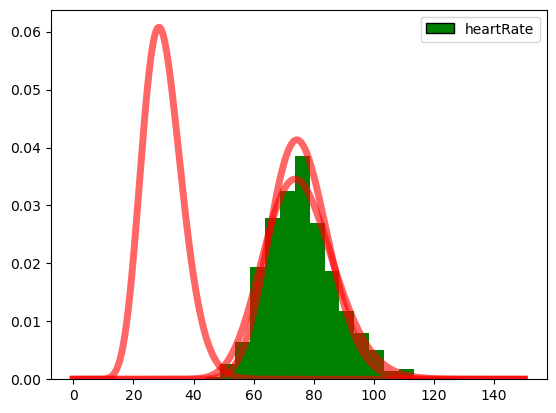

In [11]:
# plotting a gamma distribution, but not giving much success as of now
x = np.linspace(0, 150, 1000)
plt.plot(x, gamma.pdf(x, 20, scale=1.5), 'r-', lw=5, alpha=0.6, label='initial values')
plt.plot(x, gamma.pdf(x, 60.5, scale=1.25), 'r-', lw=5, alpha=0.6, label='iteration #1')
plt.plot(x, gamma.pdf(x, 42, scale=1.8), 'r-', lw=5, alpha=0.6, label='iteration #2')
#plt.plot(x, gamma.pdf(x, 14, 31, 3.2), 'b--', lw=5, alpha=0.6, label='auto fit')
plt.legend([Rectangle((0,0),1,1,color='green',ec='k')], ["heartRate"])
plt.hist(df[['heartRate']].to_numpy(), bins=20, color='green', density=True)
plt.show()

## **After** (optimum found at idx 895)

In [271]:
a, scale = data[47,:2]
a, scale

(np.float64(61.0), np.float64(0.8500000000000003))

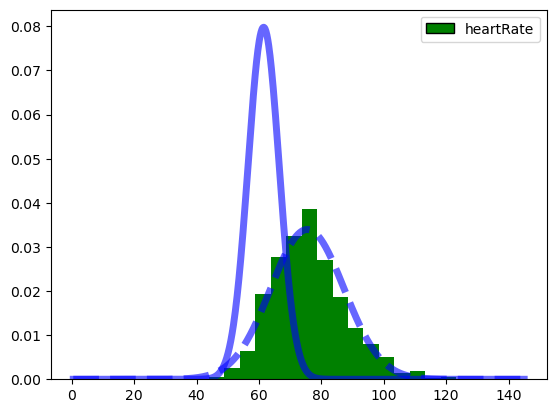

In [ ]:
# plotting a normal distribution, and doing an expectation step
# this was much easier than gamma
from scipy.stats import norm
x = np.linspace(0.5, 145, 1000)
plt.plot(x, norm.pdf(x, a, scale), 'b--', lw=5, alpha=0.6, label='norm pdf')
plt.plot(x, norm.pdf(x, 61.5, 5), 'b-', lw=5, alpha=0.6, label='norm pdf')
plt.legend([Rectangle((0,0),1,1,color='green',ec='k')], ["heartRate"])
plt.hist(df[['heartRate']].to_numpy(), bins=20, color='green', density=True)
plt.show()